In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import tqdm

import gp_aug
import regressor
import utils

import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 15

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import model_selection

torch.manual_seed(3337)
np.random.seed(3337)

In [2]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}
passband2color = {
    0: 'blue', 2: 'green', 4: 'purple',
    1: 'orange', 3: 'red', 5: 'brown'
}

In [3]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

def compile_obj(t, flux, flux_err, passband):
    obj = pd.DataFrame()
    obj['mjd']      = t
    obj['flux']     = flux
    obj['flux_err'] = flux_err
    obj['passband'] = passband
    return obj

def is_good(anobject, peak_mjd):
    if peak_mjd < anobject['mjd'].min() or peak_mjd > anobject['mjd'].max():
        return False
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        return False
    
    # keep only objects with at least 5 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 5:
            count += 1
    if count > 3:
        return False
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        return False
    
    return True

def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best',fontsize=14)
    plt.title(title, size=14)

In [4]:
def residuals_histogram(all_objects):
    plt.figure(figsize=(10, 7))
    plt.hist(all_objects['true_peakmjd'].values - all_objects['pred_peakmjd'].values, bins=50)
    plt.xlabel('mjd residuals', fontsize=15)
    plt.show()

In [5]:
def read_test_csv(filename, objects_set):
    test_idx = pd.read_csv(filename, usecols=['object_id']).object_id
    skiprows = test_idx.apply(lambda obj: obj not in objects_set).astype(bool)
    test_detected = pd.read_csv(filename, usecols=['detected_bool']).detected_bool
    skiprows |= ~test_detected.astype(bool)
    skiprows = skiprows.index[skiprows] + 1  # first row contains column names
    df = pd.read_csv(filename, skiprows=skiprows)
    return df


def GP_prepare_picture(anobject, n_obs=1000):
    model = gp_aug.GaussianProcessesAugmentation(passband2lam)
    model.fit(anobject['mjd'].values, anobject['flux'].values, 
              anobject['flux_err'].values, anobject['passband'].values)
    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(anobject['mjd'].min(), 
                                                                     anobject['mjd'].max(), n_obs=n_obs)
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    anobject_aug = anobject_aug.drop('flux_err', axis=1).set_index(['mjd', 'passband']).unstack(level=1)
    return anobject_aug.values.T, np.array(anobject_aug.index)

In [6]:
pictures = np.load('cnn_cls_data/pictures.npy')
timestamps = np.load('cnn_cls_data/timestamps.npy')[:, [0, -1]]
true_peaks = np.load('cnn_cls_data/true_peaks.npy')

In [7]:
trainval_pics, test_pics, trainval_ts, test_ts, trainval_tp, test_tp = \
    model_selection.train_test_split(pictures, timestamps, true_peaks, test_size=0.2)
train_pics, val_pics, train_ts, val_ts, train_tp, val_tp = \
    model_selection.train_test_split(trainval_pics, trainval_ts, trainval_tp, test_size=0.2)

In [8]:
train_X = train_pics
train_y = (train_tp - train_ts[:, 0]) / (train_ts[:, -1] - train_ts[:, 0])
train_y = np.log(train_y / (1 - train_y))

val_X = val_pics
val_y = (val_tp - val_ts[:, 0]) / (val_ts[:, -1] - val_ts[:, 0])
val_y = np.log(val_y / (1 - val_y))

test_X = test_pics
test_y = (test_tp - test_ts[:, 0]) / (test_ts[:, -1] - test_ts[:, 0])
test_y = np.log(test_y / (1 - test_y))

In [9]:
train_ds = torch.utils.data.TensorDataset(torch.tensor(train_X), 
                                          torch.tensor(train_y))
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)

val_ds = torch.utils.data.TensorDataset(torch.tensor(val_X), 
                                        torch.tensor(val_y))
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=8, shuffle=False)

test_ds = torch.utils.data.TensorDataset(torch.tensor(test_X), 
                                         torch.tensor(test_y))
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=8, shuffle=False)

In [16]:
device = torch.device('cuda:0')

model = nn.Sequential(
    nn.LayerNorm((6, 1000)),
    nn.Conv1d(6, 8, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool1d(5),
    nn.Conv1d(8, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool1d(4),
    nn.Conv1d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool1d(2),
    nn.Flatten(),
    nn.Linear(25 * 32, 1)
).to(device)

opt = torch.optim.Adam(model.parameters(), 3e-3)
sched = torch.optim.lr_scheduler.StepLR(opt, 20)
loss_func = nn.MSELoss()

In [17]:
def train_epoch(model, opt, loss_func, loader):
    model.train()
    running_loss = 0
    n_batches = 0
    for x, y in loader:
        pred = model(x.to(device).float()).view(-1)
        loss = loss_func(pred, y.to(device).float())
        
        opt.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
        opt.step()
        
        running_loss += loss.item()
        n_batches += 1
    return running_loss / n_batches

def eval_epoch(model, loss_func, loader):
    model.eval()
    running_loss = 0
    n_batches = 0
    with torch.no_grad():
        for x, y in loader:
            pred = model(x.to(device).float()).view(-1)
            loss = loss_func(pred, y.to(device).float())

            running_loss += loss.item()
            n_batches += 1
    return running_loss / n_batches

def train_eval(model, opt, sched, loss_func, train_loader, val_loader, n_epoch):
    best_state = None
    best_val_loss = 1e300
    
    train_hist = []
    val_hist = []
    for epoch in range(n_epoch):
        train_loss = train_epoch(model, opt, loss_func, train_loader)
        val_loss = eval_epoch(model, loss_func, val_loader)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
        
        print(f"Epoch {epoch+1}, train MSE {train_loss:.4}, val MSE {val_loss:.4}")
        
        train_hist.append(train_loss)
        val_hist.append(val_loss)
        
        sched.step()
    
    model.load_state_dict(best_state)
    model.eval()
    return train_hist, val_hist

In [18]:
result = train_eval(model, opt, sched, loss_func, train_dl, val_dl, 40)

Epoch 1, train MSE 1.186, val MSE 1.037
Epoch 2, train MSE 0.9585, val MSE 0.8856
Epoch 3, train MSE 0.9301, val MSE 0.8646
Epoch 4, train MSE 0.914, val MSE 0.8214
Epoch 5, train MSE 0.8885, val MSE 0.7987
Epoch 6, train MSE 0.886, val MSE 0.8536
Epoch 7, train MSE 0.874, val MSE 0.8495
Epoch 8, train MSE 0.8566, val MSE 0.8031
Epoch 9, train MSE 0.8263, val MSE 0.8212
Epoch 10, train MSE 0.8108, val MSE 0.8515
Epoch 11, train MSE 0.8622, val MSE 0.8067
Epoch 12, train MSE 0.843, val MSE 0.8056
Epoch 13, train MSE 0.8006, val MSE 0.8077
Epoch 14, train MSE 0.7873, val MSE 0.7999
Epoch 15, train MSE 0.7718, val MSE 0.8689
Epoch 16, train MSE 0.7765, val MSE 0.7844
Epoch 17, train MSE 0.7745, val MSE 0.8638
Epoch 18, train MSE 0.761, val MSE 0.7688
Epoch 19, train MSE 0.7652, val MSE 0.8417
Epoch 20, train MSE 0.7482, val MSE 0.8388
Epoch 21, train MSE 0.679, val MSE 0.7507
Epoch 22, train MSE 0.6412, val MSE 0.758
Epoch 23, train MSE 0.624, val MSE 0.759
Epoch 24, train MSE 0.6169, val

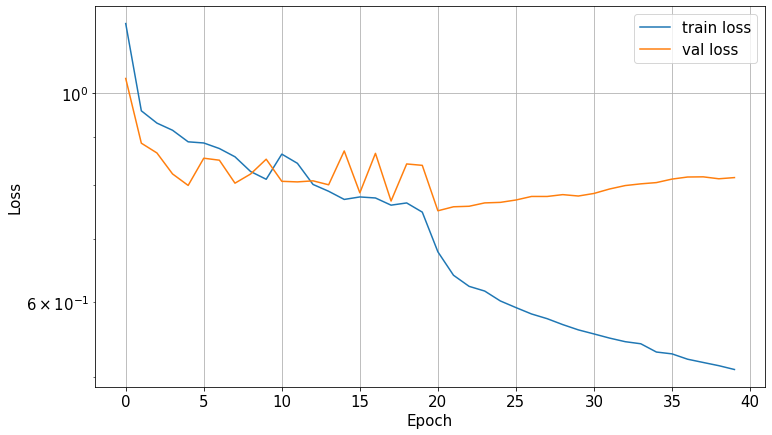

In [19]:
plt.figure(figsize=(12, 7))
plt.semilogy(result[0], label='train loss')
plt.semilogy(result[1], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [20]:
test_gt = []
test_pred = []

for batch_x, batch_y in test_dl:
    batch_pred = model(batch_x.to(device).float()).view(-1).cpu().detach().numpy()
    test_pred.extend(batch_pred)
    test_gt.extend(batch_y.detach().numpy())
    
test_gt = 1 / (1 + np.exp(-np.array(test_gt)))
test_gt = test_gt * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
test_pred = 1 / (1 + np.exp(-np.array(test_pred)))
test_pred = test_pred * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
result_df = pd.DataFrame({
    'true_peakmjd': test_gt,
    'pred_peakmjd': test_pred
})

In [21]:
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(result_df['true_peakmjd'].values, 
                                                                      result_df['pred_peakmjd'].values)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)

RMSE:  6.1280567856585035
MAE:  3.58791794905593
RSE:  0.021925644306603712
RAE:  0.014404276298118053
MAPE:  0.005959916773363598


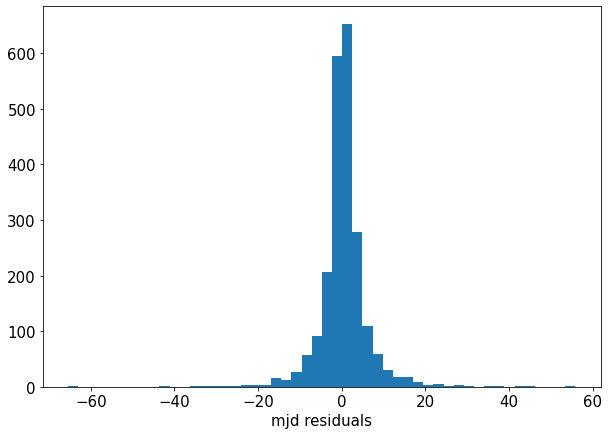

In [22]:
residuals_histogram(result_df)

In [23]:
torch.save(model.state_dict(), 'cnn_cls_data/cnn_1.pt')

In [24]:
direct_pred = []
for batch_x, _ in test_dl:
    batch_x = batch_x.detach().numpy().sum(axis=1).argmax(axis=1) / (1000 - 1)
    direct_pred.extend(batch_x)
direct_pred = np.array(direct_pred) * (test_ts[:, -1] - test_ts[:, 0]) + test_ts[:, 0]
direct_result_df = pd.DataFrame({
    'true_peakmjd': test_gt,
    'pred_peakmjd': direct_pred
})

In [26]:
[rmse, mae, rse, rae, mape] = utils.regression_quality_metrics_report(result_df['true_peakmjd'].values, 
                                                                      result_df['pred_peakmjd'].values)
[rmse_dir, mae_dir, rse_dir, rae_dir, mape_dir] = \
    utils.regression_quality_metrics_report(direct_result_df['true_peakmjd'].values, 
                                            direct_result_df['pred_peakmjd'].values)

print("\tCNN\t\tDirect")
print("RMSE:\t{:.4}\t\t{:.4}".format(rmse, rmse_dir))
print("MAE:\t{:.4}\t\t{:.4}".format(mae, mae_dir))
print("RSE:\t{:.4}\t\t{:.4}".format(rse, rse_dir))
print("RAE:\t{:.4}\t\t{:.4}".format(rae, rae_dir))
print("MAPE:\t{:.4}\t\t{:.4}".format(mape, mape_dir))

	CNN		Direct
RMSE:	6.128		11.7
MAE:	3.588		7.6
RSE:	0.02193		0.04187
RAE:	0.0144		0.03051
MAPE:	0.00596		0.01262


In [27]:
def several_residuals_histogram(dfs, names, bins=100):
    plt.figure(figsize=(12, 7))
    metrics = np.array([
        df['true_peakmjd'].values - df['pred_peakmjd'].values for df in dfs
    ])
    gen_bins = np.linspace(-1.1 * np.max(np.abs(metrics)),
                       1.1 * np.max(np.abs(metrics)), bins)
    for metric, name in zip(metrics, names):
        plt.hist(metric, bins=gen_bins,
                 alpha=1/len(dfs), label=name)
    plt.xlabel('mjd residuals', fontsize=15)
    plt.legend()
    plt.show()

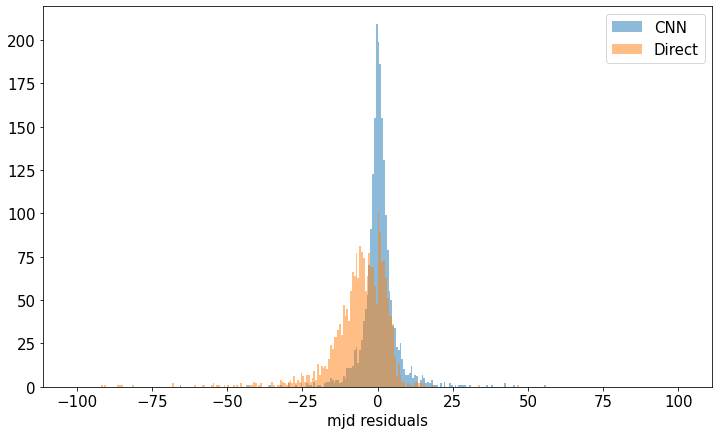

In [28]:
several_residuals_histogram([result_df, direct_result_df], ['CNN', 'Direct'], 333)

In [40]:
def plot_light_curves_with_peak_cnn(anobject, cnn_model, true_peak_mjd=None, title="", n_obs=1000, save=None):
    model = gp_aug.GaussianProcessesAugmentation(passband2lam)
    model.fit(anobject['mjd'].values, anobject['flux'].values, 
              anobject['flux_err'].values, anobject['passband'].values)
    t_aug, flux_aug, flux_err_aug, passband_aug = model.augmentation(
        anobject['mjd'].min(), 
        anobject['mjd'].max(),
        n_obs=n_obs
    )
    anobject_aug = compile_obj(t_aug, flux_aug, flux_err_aug, passband_aug)
    curve = anobject_aug[['mjd', 'flux']].groupby('mjd', as_index=False).sum()
    direct_pred_peak_mjd = curve['mjd'][curve['flux'].argmax()]
    
    anobject_aug_unstacked = anobject_aug.drop('flux_err', axis=1)\
        .set_index(['mjd', 'passband']).unstack(level=1)
    picture, time_index = anobject_aug_unstacked.values.T, np.array(anobject_aug_unstacked.index)
    with torch.no_grad():
        logit = cnn_model(torch.tensor([picture], dtype=torch.float32).to(device)).cpu().detach().numpy()[0]
    cnn_pred_peak_mjd = 1/(1+np.exp(-logit)) * (time_index[-1] - time_index[0]) + time_index[0]

    plt.figure(figsize=(12, 7))
    for passband in range(6):
        light_curve = get_passband(anobject_aug, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=1,
                 color=passband2color[passband])
        light_curve = get_passband(anobject, passband)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, 
                    label=passband2name[passband], color=passband2color[passband], linewidth=1)
    plt.plot(curve['mjd'].values, curve['flux'].values, label='Sum', linewidth=1, color='pink')

    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)

    plt.axvline(direct_pred_peak_mjd, label='Direct pred peak', color='orange')
    plt.axvline(cnn_pred_peak_mjd, label='CNN pred peak', color='blue')
    if true_peak_mjd is not None:
        plt.axvline(true_peak_mjd, label='True peak', color='black')
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)
    
    if save is not None:
        plt.savefig(save, format='pdf')
        
    plt.show()

In [41]:
metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
data = pd.read_csv('../data/plasticc/plasticc_train_lightcurves.csv.gz')
data = data[data.detected_bool == 1]
object_ids = np.unique(data.object_id)
all_objects = metadata[['object_id', 'true_peakmjd']][metadata.true_target.isin([42, 62])]
mask = all_objects.apply(lambda row: is_good(get_object(data, row['object_id']), row['true_peakmjd']), axis=1)
all_objects = all_objects[mask]

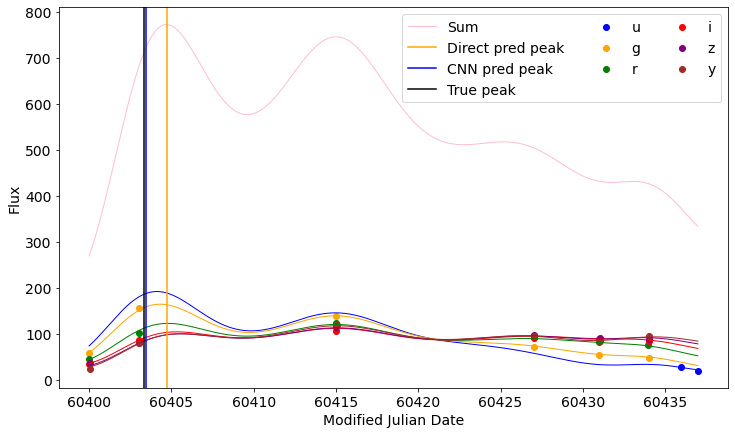

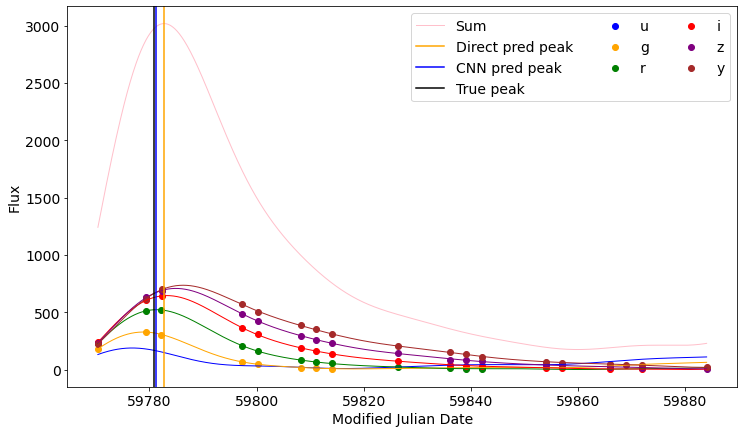

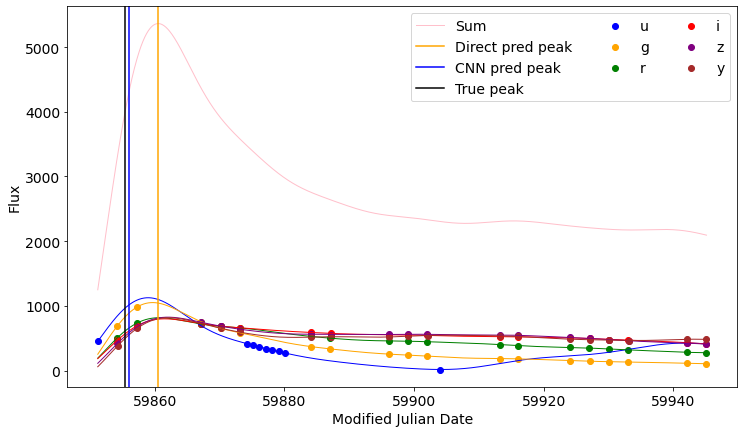

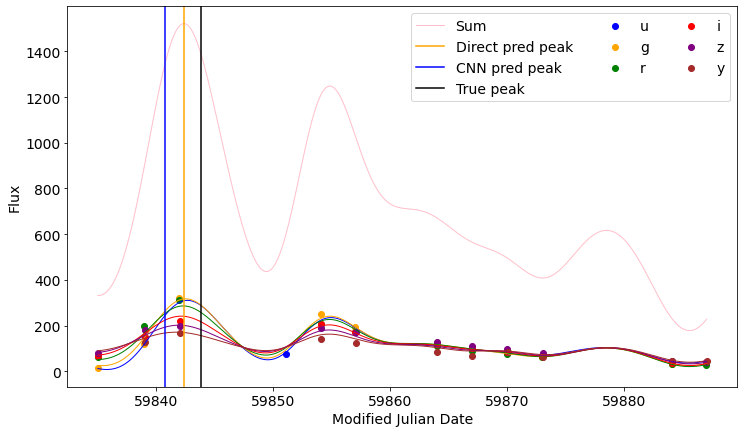

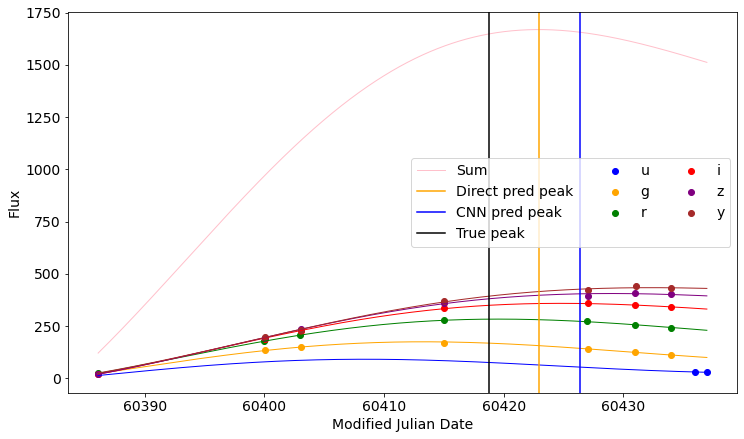

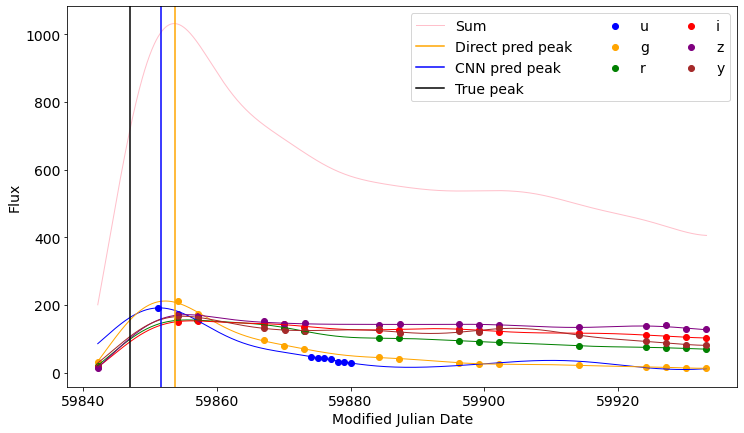

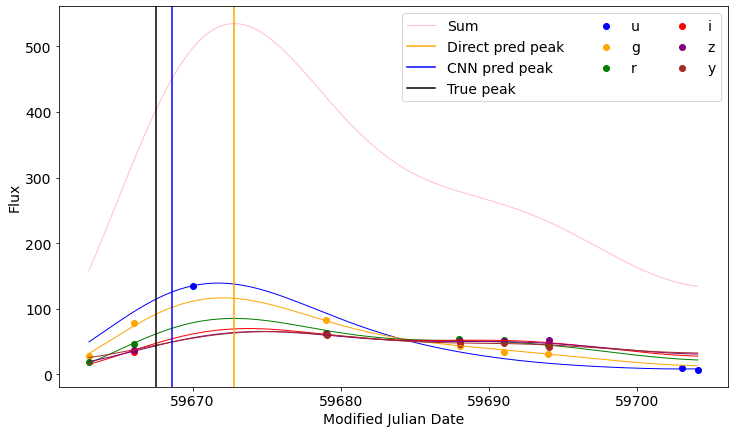

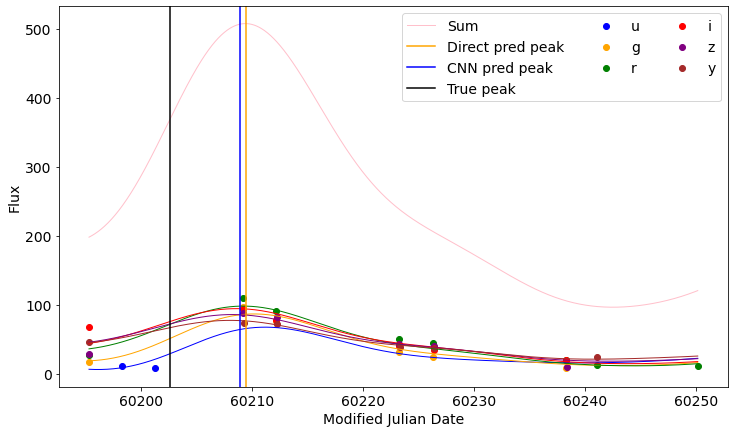

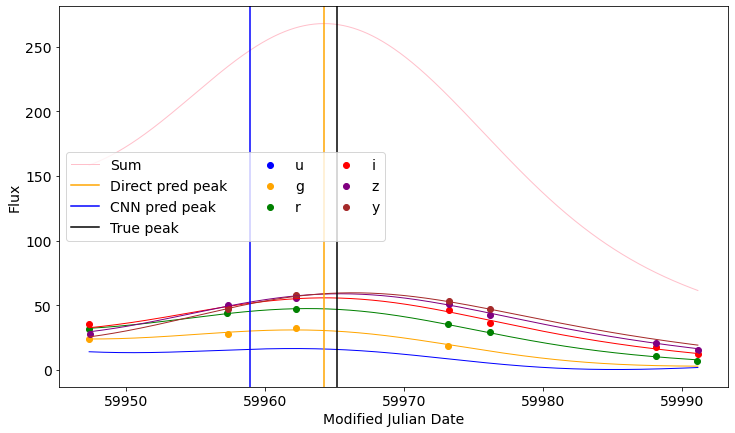

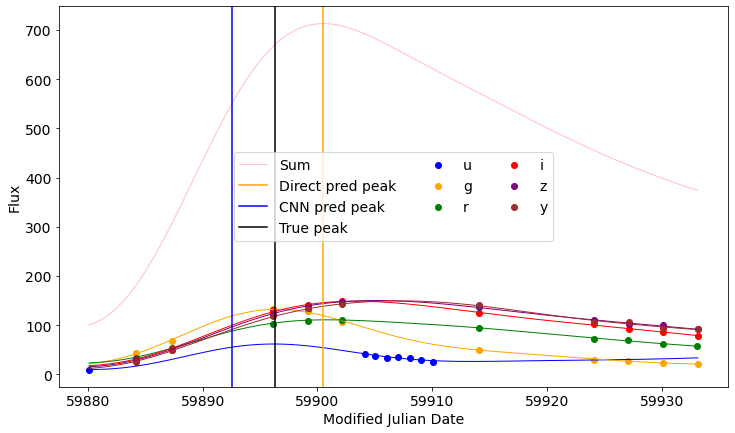

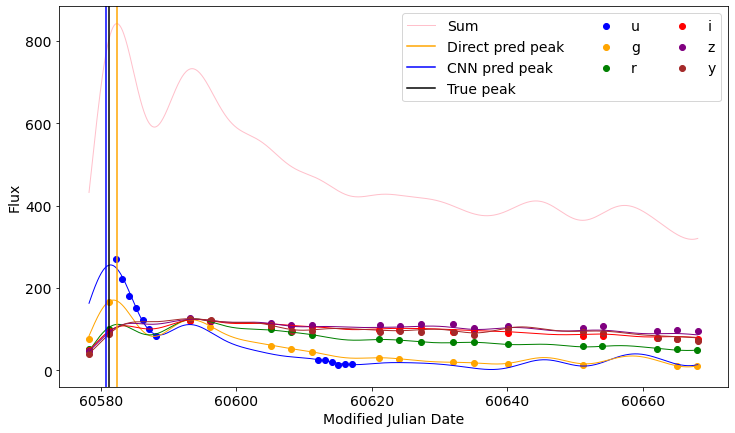

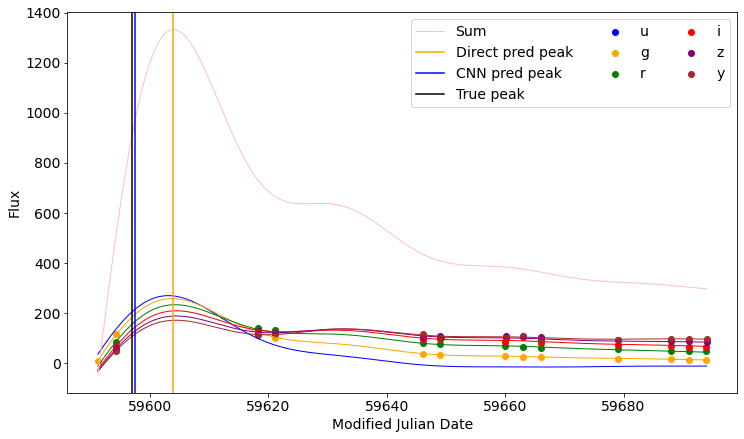

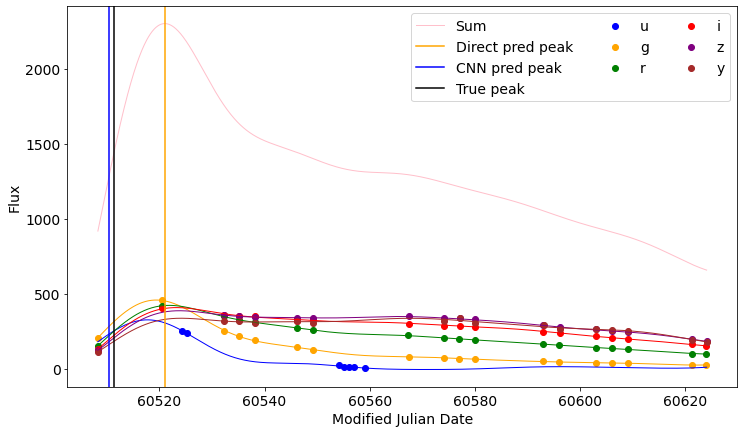

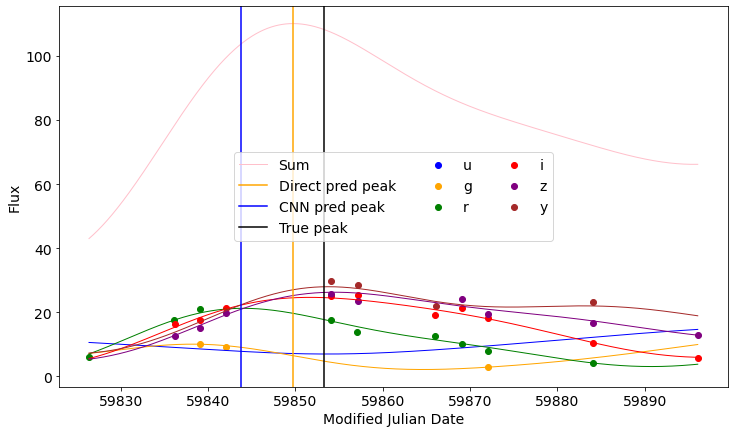

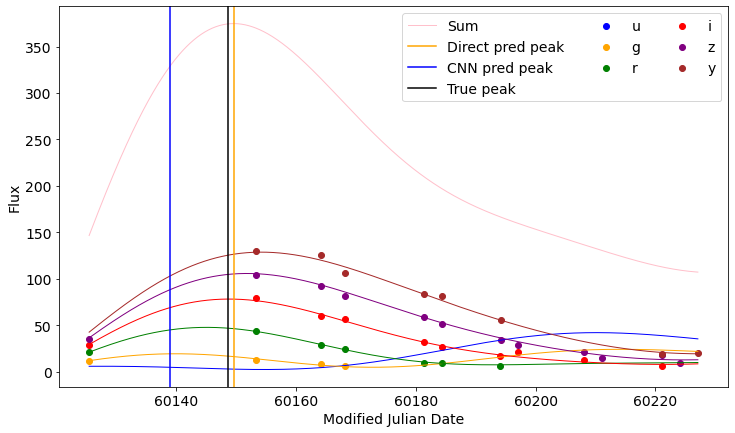

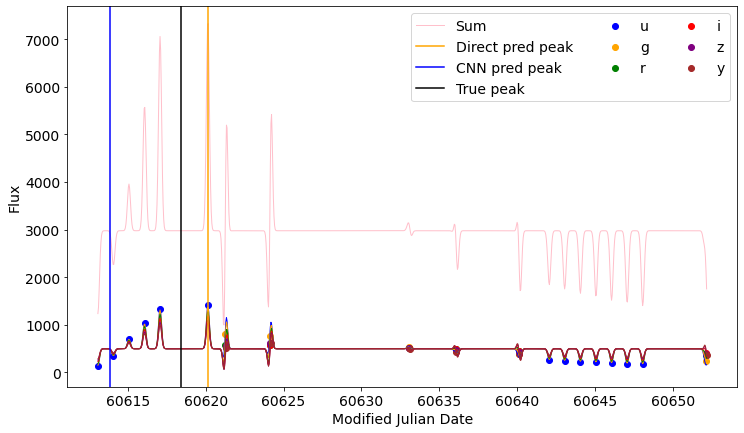

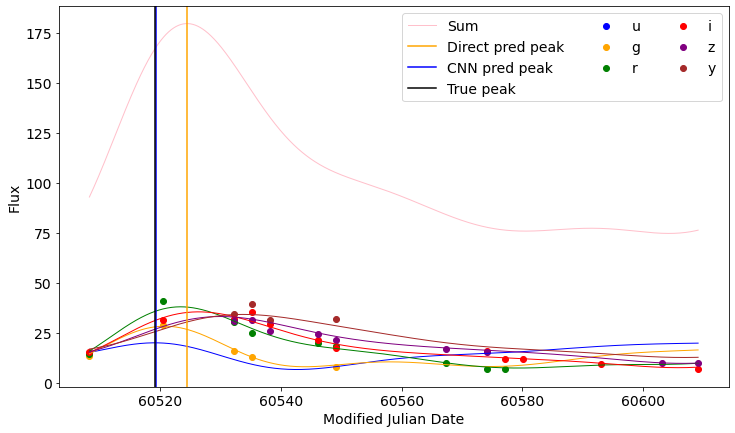

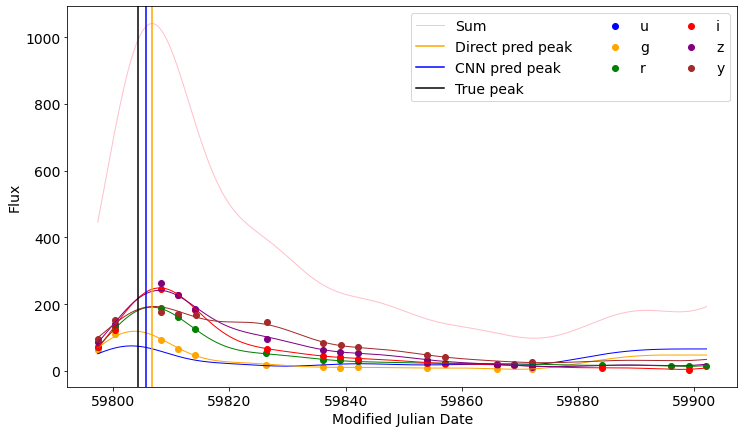

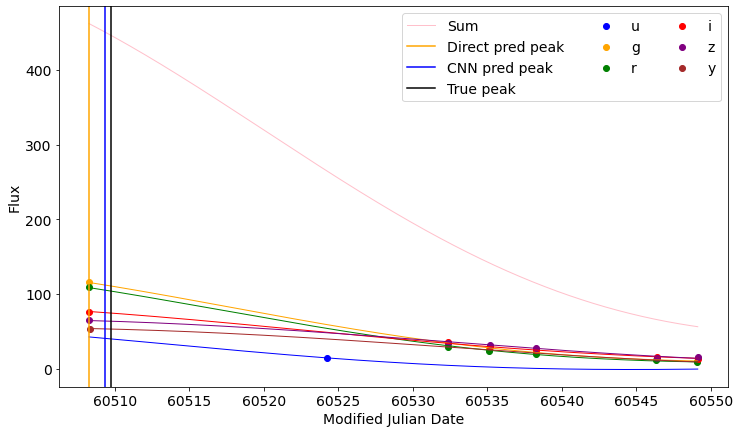

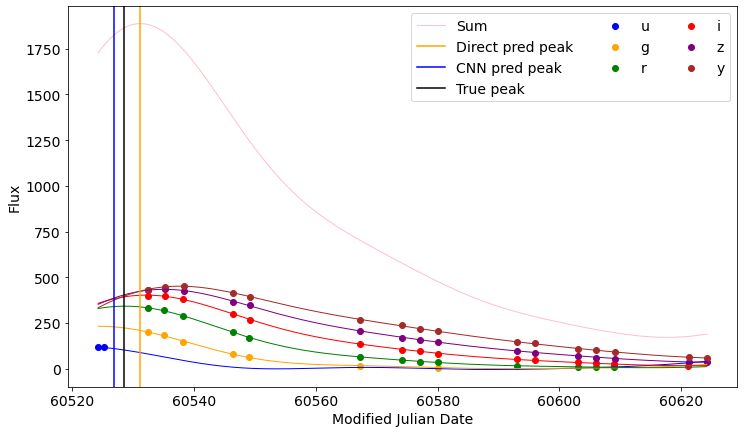

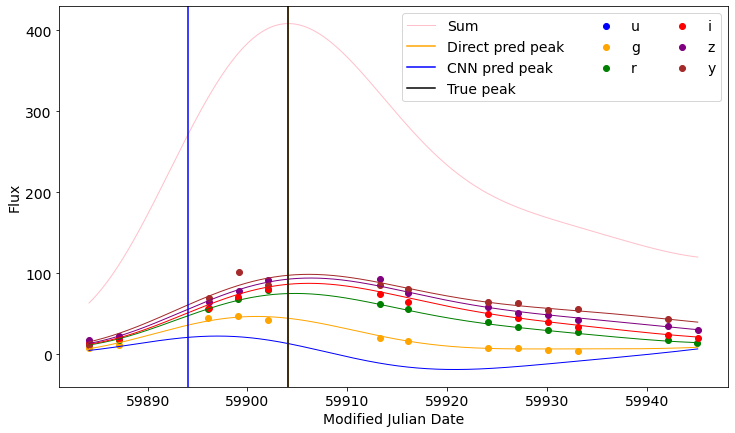

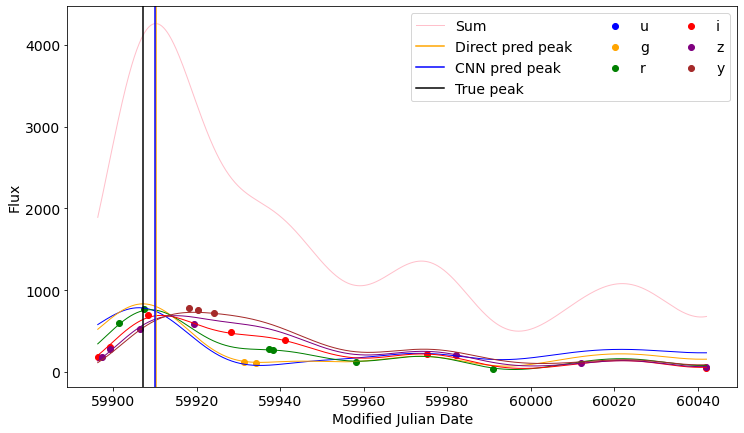

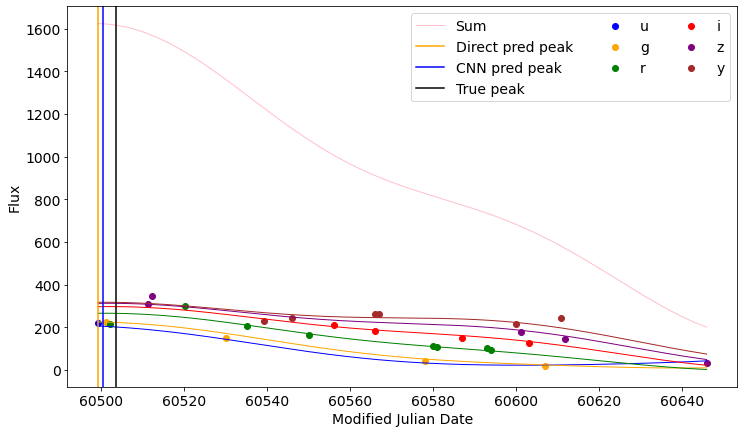

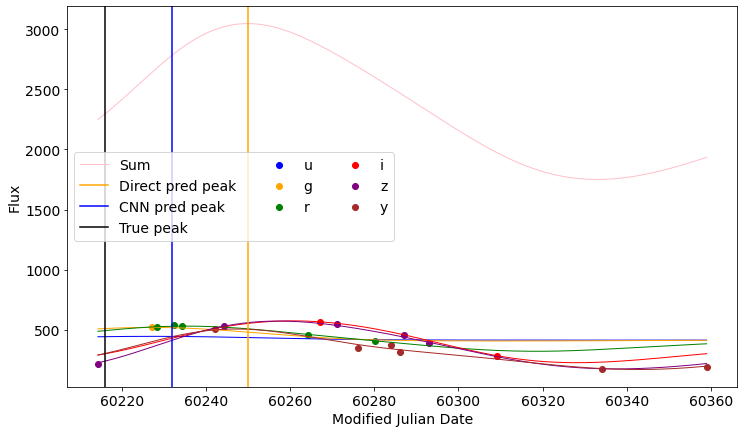

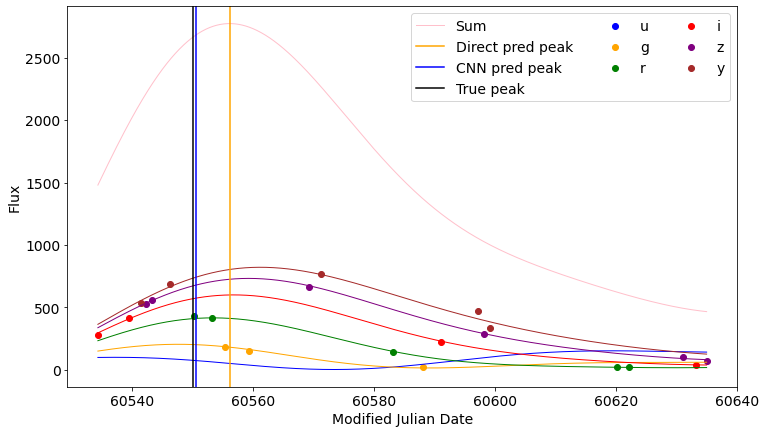

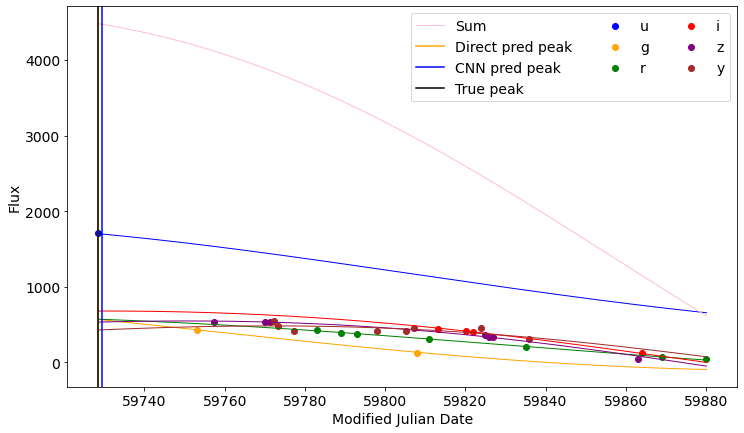

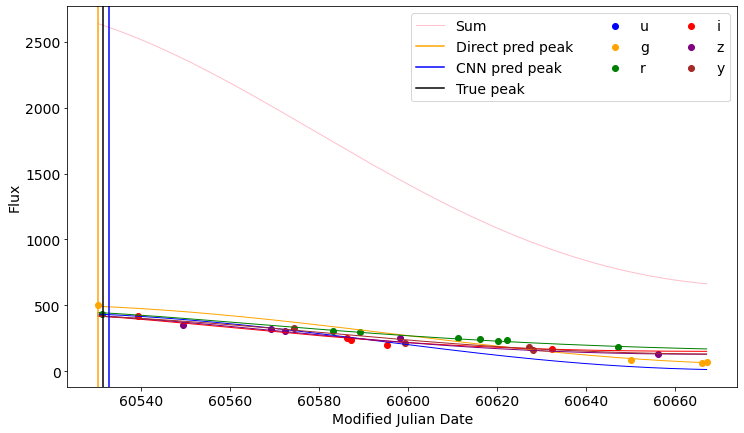

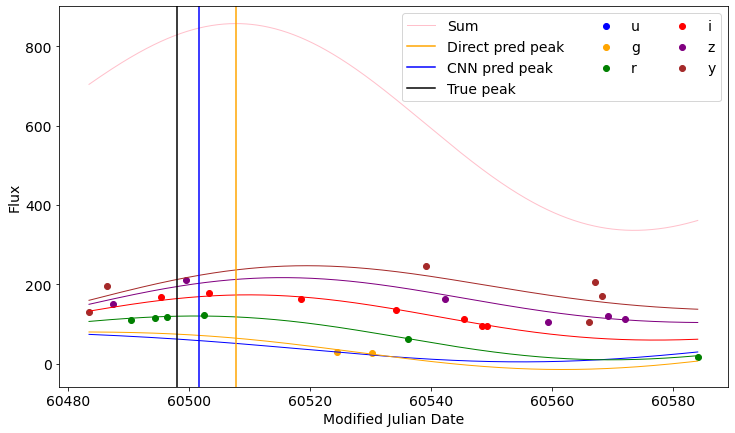

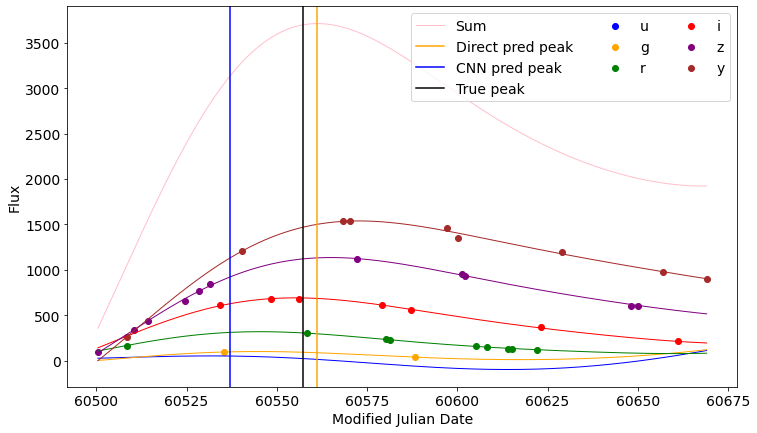

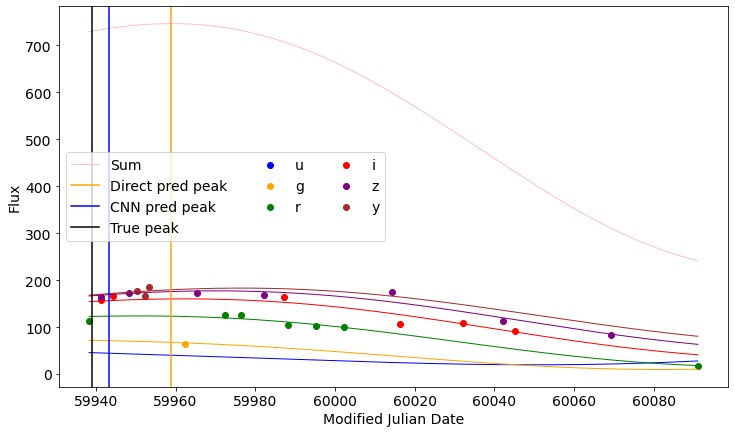

In [43]:
for object_id in all_objects['object_id'].values[::7]:
    plot_light_curves_with_peak_cnn(get_object(data, object_id), model,
                                    all_objects[all_objects['object_id']==object_id]['true_peakmjd'].iloc[0])